# Analyze and plot results from minigenome and competition validation assays

### Import modules, define directories

In [1]:
import os
import glob
import shutil
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from IPython.display import display, HTML, Markdown, Image

fastqdir = './fastq/'
paperdir = './paper'
figuresdir = os.path.join(paperdir, 'figures/')

for xdir in [fastqdir, paperdir, figuresdir]:
    if not os.path.isdir(xdir):
        os.mkdir(xdir)

In [2]:
## Set plotting parameters/preferences
# Set colors to use throughout
palette ={"None":"k",
          "Known - Human":"gray",
#           "Human":"#d95f02", 
          "A549":"#d95f02", 
          "A549 - Add":"#D95F02",
#           "Bird":"#1b9e77", 
#           "Avian":"#1b9e77", 
          "CCL141":"#1b9e77",
          "CCL141 - Add":"#1b9e77",
          "Both":"#7570b3", 
#           "Known - Both":"#7570b3",
#           "Yes": "#d95f02", 
#           "No": "gray",
           
         }
# Set matplotlib rcParams for figures
sns.set(context='paper', style='ticks', palette='deep', font='Arial', font_scale=1.042, color_codes=True,
        rc = {'font.size': 10,
 'axes.labelsize': 10,
 'axes.titlesize': 10,
 'xtick.labelsize': 8, #9,
 'ytick.labelsize': 8, #9,
 'legend.fontsize': 9,
 'axes.linewidth': 1.0,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1,
 'lines.markersize': 4.5,
 'patch.linewidth': 0.8,
 'xtick.major.width': 1.0,
 'ytick.major.width': 1.0,
 'xtick.minor.width': 0.8,
 'ytick.minor.width': 0.8,
 'xtick.major.size': 4.5,
 'ytick.major.size': 4.5,
 'xtick.minor.size': 3,
 'ytick.minor.size': 3}
       )
# sns.plotting_context()

## Minigenome assays

In [3]:
## Annotated raw flow data, write annotated data to file.
## Do not need to run again. Code block here for record only.

hostcells = ['A549', '293T']
welltoplasmidfile = 'validation/minigenome/Annot_WelltoPlasmid.txt'
plasmidtomutfile = 'validation/minigenome/Annot_PlasmidtoMutatation.txt'

renamecol = dict(zip(['Sample:', 'PE-mCherry-A+ | Freq. of Parent', 'PE-mCherry-A+/GFP-A+ | Freq. of Parent'], 
                     ['Sample', '% mCherry+', '% GFP+|mCherry+']))

for cell in hostcells:
    flowfile = 'validation/minigenome/{0}_flow.txt'.format(cell)
    flowannotfile = 'validation/minigenome/{0}_flow_withannot.txt'.format(cell)

    df = (pd.read_table(flowfile)
          .rename(columns=lambda x: x.replace('Cells/', ''))
          .rename(columns=renamecol)
          .assign(Well=lambda x: x['Sample'].str.split('_').str[2])
         )

    WellToPlasmid = (pd.read_table(welltoplasmidfile)
                     .assign(Plasmid=lambda x:x['Sample ID'].str.split(' ').str[0]) )
    PlasmidToMutation = pd.read_table(plasmidtomutfile, dtype={'Plasmid':object})
    df = pd.merge(df, WellToPlasmid, how='left', on='Well')
    df = pd.merge(df, PlasmidToMutation, how='left', on='Plasmid')

    df = df[['Site', 'Mutation', 'Selected in', 'Plasmid',
           'Plasmid name', 'Sample', '% mCherry+',
           '% GFP+|mCherry+', 'Well', 'Sample ID']].sort_values('Site')
    print('Write annotated flow data to {0}'.format(flowannotfile))
    df.to_csv(flowannotfile.format(cell), index=False)
    display(HTML(df.head().to_html(index=False)))

Write annotated flow data to validation/minigenome/A549_flow_withannot.txt


Site,Mutation,Selected in,Plasmid,Plasmid name,Sample,% mCherry+,% GFP+|mCherry+,Well,Sample ID
0,WT,None,2150,2150_HDM-S009-PB2,Specimen_001_A1_A01_001.fcs,22.9,1.75,A1,2150 1
0,WT,None,2150,2150_HDM-S009-PB2,Specimen_001_A2_A02_002.fcs,27.4,2.74,A2,2150 3
0,WT,None,2150,2150_HDM-S009-PB2,Specimen_001_A3_A03_003.fcs,24.3,3.31,A3,2150 4
9,D9K,A549,2191,2191_HDM-S009-PB2-D9K,Specimen_001_F2_F02_062.fcs,22.5,4.57,F2,2191 3
9,D9K,A549,2191,2191_HDM-S009-PB2-D9K,Specimen_001_F1_F01_061.fcs,24.0,4.33,F1,2191 2


Write annotated flow data to validation/minigenome/293T_flow_withannot.txt


Site,Mutation,Selected in,Plasmid,Plasmid name,Sample,% mCherry+,% GFP+|mCherry+,Well,Sample ID
0,WT,None,2150,2150_HDM-S009-PB2,Specimen_001_A1_A01_001.fcs,36.4,36.3,A1,2150 1
0,WT,None,2150,2150_HDM-S009-PB2,Specimen_001_A2_A02_002.fcs,39.0,36.7,A2,2150 3
0,WT,None,2150,2150_HDM-S009-PB2,Specimen_001_A3_A03_003.fcs,40.9,38.8,A3,2150 4
9,D9K,A549,2191,2191_HDM-S009-PB2-D9K,Specimen_001_F2_F02_062.fcs,45.8,49.2,F2,2191 3
9,D9K,A549,2191,2191_HDM-S009-PB2-D9K,Specimen_001_F1_F01_061.fcs,42.8,47.5,F1,2191 2


Perform t-test to identify mutations that cause significant differences in minigenome activity

In [4]:
ttestlist = []
hostcells = ['A549', '293T']
for cell in hostcells:
    flowannotfile = 'validation/minigenome/{0}_flow_withannot.txt'.format(cell)
    df = pd.read_csv(flowannotfile)
    values_wt = df[df['Mutation']=='WT']['% GFP+|mCherry+']
    groupby_mutation = df['% GFP+|mCherry+'].groupby(df['Mutation'])
    for mut, values_mut in groupby_mutation:
        t, p = stats.ttest_ind(values_wt, values_mut)
        tlog, plog = stats.ttest_ind(np.log10(values_wt), np.log10(values_mut))
        ttestlist.append([cell, mut, p, plog])
df_ttest = pd.DataFrame(ttestlist, columns=['Cell', 'Mutation', 'p', 'p (of log values)'])
df_ttest['Annotation'] = np.where(df_ttest['p']<=.05, '*', '')

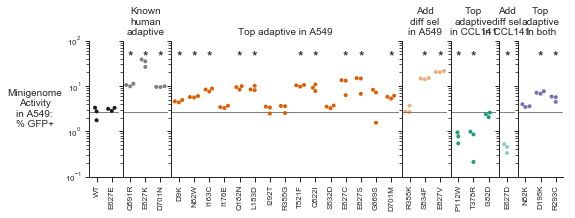

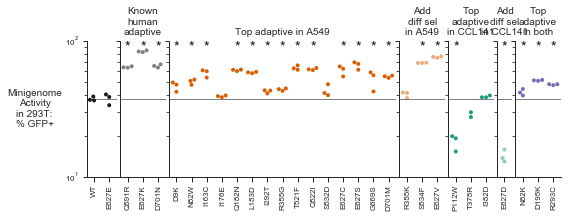

In [5]:
hostcells = ['A549', '293T']
xaxis = 'Mutation'
ymetric = '% GFP+|mCherry+'
categories = [('None', ''), 
              ('Known - Human', 'Known\nhuman\nadaptive'), 
              ('A549', 'Top adaptive in A549'), 
              ('A549 - Add', 'Add\ndiff sel\nin A549'),
              ('CCL141', 'Top\nadaptive\nin CCL141'), 
              ('CCL141 - Add', 'Add\ndiff sel\nin CCL141'),
              ('Both', 'Top\nadaptive\nin both')]
ylim = {'A549': [0.1, 100],
       '293T': [10, 100]}
ypval = {'A549': 30,
         '293T': 80}

for cell in hostcells:
    flowannotfile = 'validation/minigenome/{0}_flow_withannot.txt'.format(cell)
    df = pd.read_csv(flowannotfile)
    # Get WT mean to annotate plots
    WTmean = df[df['Mutation']=='WT']['% GFP+|mCherry+'].mean()
    # Set up plots
    ylabel = 'Minigenome\nActivity\nin {0}:\n% GFP+'.format(cell)
    fig, axes = plt.subplots(1,7, 
                             figsize=(17*0.5,2.5),
                             gridspec_kw = {'width_ratios':[2, 3, 15, 3, 3, 1, 3]})
    plt.subplots_adjust(wspace=0.05)
    for i, (cat, catlab) in enumerate(categories):
        dftemp = df[df['Selected in']==cat]
        c = palette[cat]
        ax = axes.flat[i]
        ax.set_yscale("log", basey=10)
        ax.set_ylim(ylim[cell])
        
        if (cat=='A549 - Add' or cat=='CCL141 - Add'):
            g = sns.swarmplot(x=xaxis, y=ymetric, data=dftemp, 
                              ax=ax, s=4, color=c, alpha=.5,
                         )
        else:
            g = sns.swarmplot(x=xaxis, y=ymetric, data=dftemp, 
                          ax=ax, s=4, color=c,
                     )
        
        # Annotate t-test p-val
        for muti, mut in enumerate(dftemp.Mutation.unique()):
            annot = df_ttest.loc[((df_ttest['Cell']==cell) & (df_ttest['Mutation']==mut)), 'Annotation'].values[0]
            ax.text(muti, ypval[cell], annot, ha='center', va='bottom', color='k', fontsize=14)
        sns.despine()
        ax.set_xlabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
        ax.set_title(catlab, fontsize=10)
        ax.axhline(WTmean, color='gray', linewidth=1)
        ax.set_yticklabels([], minor=True)
        if i==0:
            ax.set_ylabel(ylabel, 
                         rotation='horizontal', va='center', labelpad=30)
        else:
            ax.set_ylabel('')
            ax.set_yticklabels([])
    fig.savefig('validation/minigenome/minigenome_{0}.pdf'.format(cell), bbox_inches="tight", dpi=300)

## Competition assays

### Read in sample sheet and download data

In [6]:
comptfolder = 'validation/competition'

samples = (pd.read_table('validation/competition/SraRunTable_compt.txt', sep='\t')
           [['Sample_Name', 'lab_host', 'Timepoint', 'Mutant', 'replicate', 'Run', 'Library_Name', ]]
           .sort_values('Library_Name')
           .rename(columns={'replicate':'BioRep'})
          )

samples['Cell'] = samples.apply(lambda x:x['lab_host'].split(sep=' ')[0],axis=1)
samples['file'] = samples.apply(lambda x:x['Library_Name']+'.fastq.gz',axis=1)

display(HTML(samples.head().to_html(index=False)))

Sample_Name,lab_host,Timepoint,Mutant,BioRep,Run,Library_Name,Cell,file
compt_R355G_1_A549_10hpi,A549 cells,10,R355G,1,SRR8375145,A-10-10,A549,A-10-10.fastq.gz
compt_S532D_1_A549_10hpi,A549 cells,10,S532D,1,SRR8375144,A-10-11,A549,A-10-11.fastq.gz
compt_G669S_1_A549_10hpi,A549 cells,10,G669S,1,SRR8375051,A-10-12,A549,A-10-12.fastq.gz
compt_N82K_1_A549_10hpi,A549 cells,10,N82K,1,SRR8375054,A-10-13,A549,A-10-13.fastq.gz
compt_T378R_1_A549_10hpi,A549 cells,10,T378R,1,SRR8375053,A-10-14,A549,A-10-14.fastq.gz


In [7]:
use_existing = True # Whether to use existing files

downloadfiles = dict(zip(list(samples['Run']), list(samples['file'])))
print('Downloading fastq files', end=' ')
for run, file in downloadfiles.items():
    filenameold = os.path.join(fastqdir, '{0}.fastq.gz'.format(run))
    filenamenew = os.path.join(fastqdir, file)
    if os.path.isfile(filenamenew) and use_existing:
        print('x', end='')
    else:
        print('.', end='')
        log = !fastq-dump --outdir $fastqdir --gzip $run
        log = !mv $filenameold $filenamenew
print('Done')

### Count number of reads mapping to WT/mutant sequence in fastq files

In [8]:
# read in reference sequences to match to
RefSeq_df = pd.read_table(os.path.join(comptfolder, 'MutantRefSeq.txt') )\
    .set_index('Mutant')
RefSeq = RefSeq_df.to_dict()

# Count reads mapping to WT/mutant sequences, save to dataframe/file
SampleSheet = samples[['Sample_Name', 'Library_Name', 'Cell', 'Timepoint', 'BioRep', 'Mutant', 'file']]
countsdf = SampleSheet.reindex( columns = SampleSheet.columns.tolist() + ['TotalReads','WtReads','MutReads'])
for i, row in SampleSheet.iterrows():
    fastq = os.path.join(fastqdir, row['file'])
    seq_wt = RefSeq['seq_wt'][row['Mutant']]
    seq_mut = RefSeq['seq_mut'][row['Mutant']]
    TotalReads = !zcat $fastq | wc -l
    WtReads = !zgrep -c $seq_wt $fastq
    MutReads = !zgrep -c $seq_mut $fastq
    countsdf.loc[i,'TotalReads'] = int(TotalReads[0])/4
    countsdf.loc[i,'WtReads'] = int(WtReads[0])
    countsdf.loc[i,'MutReads'] = int(MutReads[0])
countsdf.to_csv(path_or_buf='validation/competition/competition_counts.txt', sep='\t', index=False)

In [9]:
countsdf.head()

,Sample_Name,Library_Name,Cell,Timepoint,BioRep,Mutant,file,TotalReads,WtReads,MutReads
89,compt_R355G_1_A549_10hpi,A-10-10,A549,10,1,R355G,A-10-10.fastq.gz,378336.0,225854.0,108892.0
90,compt_S532D_1_A549_10hpi,A-10-11,A549,10,1,S532D,A-10-11.fastq.gz,252360.0,160831.0,21663.0
7,compt_G669S_1_A549_10hpi,A-10-12,A549,10,1,G669S,A-10-12.fastq.gz,466655.0,325608.0,101072.0
4,compt_N82K_1_A549_10hpi,A-10-13,A549,10,1,N82K,A-10-13.fastq.gz,338068.0,209271.0,96922.0
5,compt_T378R_1_A549_10hpi,A-10-14,A549,10,1,T378R,A-10-14.fastq.gz,457516.0,381797.0,21834.0


### Calculate enrichment and plot

I calculated enrichment in A549 over CCL141 cells for each mutant at each timepoint as follows:

$$
\begin{align}
Enrichment = \frac{\left(count_{mut}^{A549}\right) /
\left(count_{wt}^{A549}\right)}
{\left(count_{mut}^{CCL141}\right) /
\left(count_{wt}^{CCL141}\right)} \\
\end{align}
$$

In [10]:
# First get countmut/countwt for each respective cell
countsdf = countsdf[['Cell', 'Timepoint', 'BioRep', 'Mutant', 'WtReads', 'MutReads']].copy()
countsdf['Mut/WT'] = countsdf['MutReads']/countsdf['WtReads']
#Then calculate this enrichment ratio comparing cell types 
countsdf_A549 = countsdf[countsdf['Cell']=='A549']
countsdf_CCL141 = countsdf[countsdf['Cell']=='CCL141']
countsdf2 = pd.merge(countsdf_A549, countsdf_CCL141, how='inner', 
                     on=['Timepoint', 'BioRep', 'Mutant'], 
                     suffixes=['_A', '_C'])
countsdf2['EnrichmentInA549'] = countsdf2['Mut/WT_A']/countsdf2['Mut/WT_C']
countsdf2 = countsdf2[['Timepoint', 'BioRep', 'Mutant', 'EnrichmentInA549']]
countsdf2.head()

,Timepoint,BioRep,Mutant,EnrichmentInA549
0,10,1,R355G,1.421011
1,10,1,S532D,0.370057
2,10,1,G669S,0.522676
3,10,1,N82K,0.754000
4,10,1,T378R,0.133511


Attempted a t-test, but with only two biological replicates, I don't have enough power to detect significant differences even for ratios which are very clearly different from 1.

In [11]:
ttestlist = []
timepoint = [10, 48]
for tp in timepoint:
    dftemp = countsdf2[countsdf2['Timepoint']==tp]
    groupby_mutation = dftemp['EnrichmentInA549'].groupby(dftemp['Mutant'])
    for mut, values_mut in groupby_mutation:
        t, p = stats.ttest_1samp(values_mut, 1)
        tlog, plog = stats.ttest_1samp(np.log10(values_mut), 1)
        ttestlist.append([tp, mut, p, plog])

In [12]:
# Performed a 1-sample t-test (compare enrichment ratio of 2 biological duplicates to expected ratio of 1)
# I think having only 2 replicates results in low power to detect significant differences.
# Almost all p-values are not significant, even for ratios which are clearly very different from 1.
# timepoint, mutation, p-value, p-value (for log10 of enrichment ratio)
ttestlist

[[10, 'D701M', 0.49798384662847317, 0.28713683159664083],
 [10, 'D9K', 0.22715050126319244, 0.10497315144847792],
 [10, 'E627C', 0.436188600539927, 0.5426118809234147],
 [10, 'E627D', 0.13771910465579262, 0.16494026850790705],
 [10, 'E627E', 0.4117363996008914, 0.07516514216088578],
 [10, 'E627K', 0.2795115816316993, 0.6256563537258839],
 [10, 'G669S', 0.6596819630155071, 0.24481788023497483],
 [10, 'I163C', 0.29930327849754607, 0.3637897330605934],
 [10, 'I292T', 0.3062353413866429, 0.056780311955288314],
 [10, 'N82K', 0.584598337991298, 0.2115258217205272],
 [10, 'N82W', 0.5058531167187879, 0.1981313951176301],
 [10, 'R355G', 0.39986571624316286, 0.1967909319344905],
 [10, 'R355K', 0.04154927153860988, 0.017682846251944127],
 [10, 'S532D', 0.2841842711102246, 0.08040920346603761],
 [10, 'S534F', 0.45181366801600753, 0.3039625889604902],
 [10, 'T378R', 0.015282885733514183, 0.027142600013068795],
 [10, 'T521F', 0.2727109505075636, 0.15433569156077137],
 [48, 'D701M', 0.487080676518871

In [13]:
# Make dictionary of where mutations are selected in, for plotting downstream
AnnotateMut = pd.read_table('validation/competition/Annot_PlasmidtoMutatation.txt')[['Mutation', 'Selected in']].drop_duplicates()
AnnotateMutDict = dict(zip(AnnotateMut['Mutation'], AnnotateMut['Selected in']))

In [16]:
## Dataframes for plotting
# Make a dataframe with NaN at timepoint 0 (for plotting actual data)
dffinal = countsdf2
dfaddzero = dffinal[dffinal['Timepoint']==10].copy()
dfaddzero['Timepoint'] = 0
dfaddzero['EnrichmentInA549']=np.NaN
dffinal = pd.concat([dfaddzero, dffinal])
# Make a dataframe with assumed enrichment (=1) for timepoint 0, 
# and NaN at timepoint 48 (for plotting assumed start at enrichment ratio of 1)
dffinal2 = dffinal.copy()
dffinal2.loc[dffinal2['Timepoint']==0, 'EnrichmentInA549']=1
dffinal2.loc[dffinal2['Timepoint']==48, 'EnrichmentInA549']=np.NaN

In [17]:
# Set ymin/max based on spread of data
ymetric = 'EnrichmentInA549'
print(dffinal[ymetric].min(), dffinal[ymetric].max())
ymin, ymax = 0.01, 250
# Order to plot
ordered = ['E627E',
           'E627K',
           'D9K', 'N82W', 'I163C', 'I292T', 'R355G', 'T521F', 'S532D', 'E627C', 'G669S', 'D701M', 
           'R355K', 'S534F',
           'T378R', 'E627D',
           'N82K',]
print(len(ordered))

0.012585635282365894 190.31403504324564
17


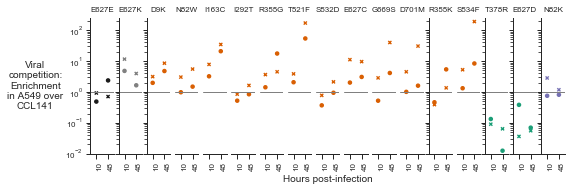

In [18]:
fig, axes = plt.subplots(1, len(ordered), figsize=(len(ordered)*0.5,2.5))
for i, mut in enumerate(ordered):
    ax = axes.flat[i]
    c = palette[AnnotateMutDict[mut]]
    dftempA = countsdf2[countsdf2['Mutant']==mut]
    dftempA1 = dftempA[dftempA['BioRep']==1]
    dftempA2 = dftempA[dftempA['BioRep']==2]
    ax.set_yscale("log", basey=10)
    ax.set_ylim([ymin, ymax])
    
    g = sns.pointplot(x='Timepoint', y=ymetric, data=dftempA1, ax=ax, color=c, linestyles=[""])
    g = sns.pointplot(x='Timepoint', y=ymetric, data=dftempA2, ax=ax, color=c, linestyles=[""], markers='x')
    
    plt.setp(ax.lines, linewidth=1)
    plt.setp(ax.collections, sizes=[10])
    g.set_title(mut, fontsize=8)
    ax.axhline(1, color='gray', linewidth=1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='left')
    if i==0:
        sns.despine(ax=ax)
        g.set_ylabel('Viral\ncompetition:\nEnrichment\nin A549 over\nCCL141', 
                     rotation='horizontal', va='center', labelpad=30)
    elif i in [0, 1, 2, 12, 14, 15, 16]:
        sns.despine(ax=ax)
        g.set_ylabel('')
        g.set_yticklabels([])
    else:
        sns.despine(ax=ax, left=True)
        g.set_ylabel('')
        g.set_yticklabels([])
        g.set_yticks([], minor=True)
        g.set_yticks([], minor=False)
    if i == int(len(ordered)/2):
        g.set_xlabel('Hours post-infection')
    else:
        g.set_xlabel('')
        
fig.savefig('validation/competition/competition.pdf', bbox_inches="tight", dpi=300)

## Copy files to paper figures directory

In [19]:
paperdir = './paper'
figuresdir = os.path.join(paperdir, 'figures/')
myfiguresdir = os.path.join(figuresdir, 'Fig4/')
if not os.path.isdir(myfiguresdir):
    os.mkdir(myfiguresdir)

files = (['validation/minigenome/{0}_flow_withannot.txt'.format(cell) 
          for cell in hostcells] +
         ['validation/minigenome/minigenome_{0}.pdf'.format(cell) 
          for cell in hostcells] +
         ['validation/competition/competition_counts.txt',
          'validation/competition/competition.pdf']
        )
for f in files:
    shutil.copy(f, myfiguresdir)